# ALS Project

## FVC measurements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
from eda_functions import *
from collections import defaultdict
from scipy.stats import linregress

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Functions

In [4]:
def plot_fvc_long(df, feature, time, subject_list, xlim=None):
    plt.figure(figsize=(12,6))
    for subject in subject_list:
        this_df = df[ df['subject_id']==subject]
        if ~this_df['']
        plt.plot(this_df[time], this_df[feature])
    #plt.axhline(100)
    plt.title("FVC, ={}".format(feature))
    plt.ylabel(feature)
    plt.xlabel(time)
    plt.xlim(xlim)
    #plt.ylim(2,5)

In [5]:
def linreg_scalers(df, subject_col, y_col, x_col, y_label):
    '''
    creates linear regression slopes, intercepts for every subject in a df.
    input:
        df = df
        subjects_list = list of unique subject names
        subject_col = name of subject id column
        y_col1 = name of first y data column
        x_col = name of column with x values 
    output:
        regression outputs in dataframe
    '''
    slopes = defaultdict()
    
    # list of every subject in table 
    subjects_list = list(np.unique(df[subject_col]))
    
    # for each subject
    for subj in subjects_list:
        data = df.loc[ df[subject_col]==subj].copy()
        y=data[y_col]
        x=data[x_col]

        # if only one record then skip
        if len(data)==1:
            continue
        # if missing values in x or y then skip
        if ~(y.isnull().any())  or (x.isnull().any()):
            y=np.array(y)
            x=np.array(x)
            # linregress is part of scipy.stats. 
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            slopes[subj] = (y_label, slope, intercept)

    # format as dataframe
    full_result = pd.DataFrame(slopes).transpose().reset_index()
    
    # relabel columns
    s_label = "slope_" + y_label 
    i_label = "intercept_" + y_label
    full_result.rename(index=str, columns={"index": "subject_id", 
                                      0: "test" ,1: s_label, 
                                      2: i_label }, inplace=True)
    
    # make small table
    mini_table = slope_mini_table(full_result.copy(), i_label)
    
    # return table
    return full_result, mini_table

def slope_mini_table(df, i_label):
    df.drop(['test', i_label], axis=1, inplace=True)
    df.dropna(axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

## FVC

In [7]:
fvc = pd.read_csv("data/Fvc.csv")

In [8]:
print(fvc.shape)
fvc.head()

(48856, 10)


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Forced_Vital_Capacity_Delta,Subject_Normal,Forced_Vital_Capacity_Units
0,89,2.89,NaN,NaN,NaN,NaN,NaN,0.0,3.83,NaN
1,329,2.49,97.0,2.57,NaN,2.60,NaN,0.0,NaN,NaN
2,329,2.71,101.0,2.62,NaN,2.72,NaN,16.0,NaN,NaN
3,329,2.75,103.0,2.62,NaN,2.53,NaN,42.0,NaN,NaN
4,329,2.79,104.0,2.62,NaN,2.61,NaN,72.0,NaN,NaN


In [9]:
# change Forced_Vital_Capacity_Delta to study day
fvc['study_day'] = fvc['Forced_Vital_Capacity_Delta']
fvc.drop('Forced_Vital_Capacity_Delta', axis=1, inplace=True)

In [10]:
plt.plot(fvc_death['day_since_onset'],fvc_death['pct_of_Normal_Trial_1'])

NameError: name 'fvc_death' is not defined

/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


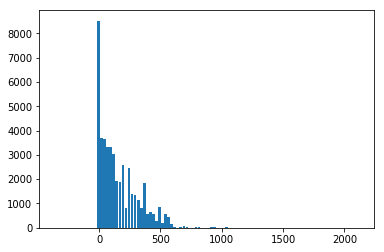

In [11]:
# hist of study days for fvc
plt.hist(fvc['study_day'], bins=100, rwidth=0.9)
plt.show()

In [12]:
print(fvc.shape)
fvc.head()

(48856, 10)


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0
1,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0
2,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0
3,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0
4,329,2.79,104.0,2.62,NaN,2.61,NaN,NaN,NaN,72.0


### Add onset data

In [13]:
# add the onset date data
onset = pd.read_csv("clean_data/onset_date.csv")

In [14]:
fvc_onset = fvc.merge(onset, how='left', on='subject_id')

In [15]:
fvc_onset['day_since_onset']= np.abs(fvc_onset['Onset_Delta']) + fvc_onset['study_day']
fvc_onset.drop(['Onset_Delta','delta_onset_diag'], axis=1, inplace=True )
print(fvc_onset.shape)
fvc_onset.head()

(48856, 11)


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,day_since_onset
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0,NaN
1,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0,1706.0
2,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0,1722.0
3,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0,1748.0
4,329,2.79,104.0,2.62,NaN,2.61,NaN,NaN,NaN,72.0,1778.0


## Add death day

In [16]:
death = pd.read_csv("clean_data/death_date.csv")

In [139]:
fvc_death = fvc_onset.merge(death, how='left', on='subject_id')
print(fvc_death.shape)
fvc_death.head(50)

(48856, 12)


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,day_since_onset,death_day_since_onset
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0,NaN,NaN
1,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0,1706.0,NaN
2,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0,1722.0,NaN
3,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0,1748.0,NaN
4,329,2.79,104.0,2.62,NaN,2.61,NaN,NaN,NaN,72.0,1778.0,NaN
5,329,2.24,103.0,2.44,NaN,2.57,NaN,NaN,NaN,135.0,1841.0,NaN
6,329,2.52,95.0,2.34,NaN,2.54,NaN,NaN,NaN,189.0,1895.0,NaN
7,329,2.40,89.0,2.20,NaN,2.37,NaN,NaN,NaN,247.0,1953.0,NaN
8,329,2.45,92.0,2.39,NaN,2.42,NaN,NaN,NaN,274.0,1980.0,NaN
9,406,3.69,NaN,NaN,NaN,NaN,NaN,4.43,NaN,0.0,NaN,NaN


In [140]:
sum(fvc_death[ fvc_death['subject_id']==708]['death_day_since_onset'].isna())

0

In [20]:
#death_w_fvc liters
fvc_death_liters = fvc_death[['subject_id', 'Subject_Liters_Trial_1', 'day_since_onset', 'death_day_since_onset']].dropna().copy()
print(fvc_death_liters.shape)
fvc_death_liters.head()


(10684, 4)


,subject_id,Subject_Liters_Trial_1,day_since_onset,death_day_since_onset
26,708,2.69,1070.0,1320.0
27,708,2.71,1077.0,1320.0
28,708,2.79,1105.0,1320.0
29,708,2.55,1133.0,1320.0
30,708,2.33,1189.0,1320.0


In [21]:
#death_w_fvc percent of normal
fvc_death_normal = fvc_death[['subject_id', 'pct_of_Normal_Trial_1', 'day_since_onset', 'death_day_since_onset']].dropna().copy()
print(fvc_death_normal.shape)
fvc_death_normal.head()


(4508, 4)


,subject_id,pct_of_Normal_Trial_1,day_since_onset,death_day_since_onset
26,708,51.0,1070.0,1320.0
27,708,51.0,1077.0,1320.0
28,708,62.0,1105.0,1320.0
29,708,48.0,1133.0,1320.0
30,708,44.0,1189.0,1320.0


In [23]:
#how many the same subject between groups?
len(set(fvc_death_normal['subject_id']) & set(fvc_death_liters['subject_id']))

863

## Cluster the FVC and death

In [40]:
from sklearn.cluster import KMeans
def cluster(df, params):
    k=KMeans(**params).fit(df)
    result = pd.DataFrame(k.labels_, columns=["kmeans_label"])
    cluster_result = pd.concat([cluster_X, result], axis=1)
    return cluster_result

In [46]:
# plot the labels for each feature
def plot_cluster(df):
    plt.figure(figsize=(12,6))
    for col in list(df.columns):
        plt.scatter(cluster_result['death_day_since_onset'], cluster_result[col], 
                    c=cluster_result['kmeans_label'])
        plt.title(col)
        plt.xlabel('death_day_since_onset')
        plt.show()

In [42]:
# get the min fvc value for each subject.
min_normal_fvc = fvc_death_normal.groupby('subject_id').min().reset_index()
min_normal_fvc.head()

,subject_id,pct_of_Normal_Trial_1,day_since_onset,death_day_since_onset
0,708,33.0,1070.0,1320.0
1,3981,78.0,210.0,292.0
2,6483,62.0,437.0,670.0
3,6673,0.0,1170.0,1253.0
4,8258,34.0,911.0,1498.0


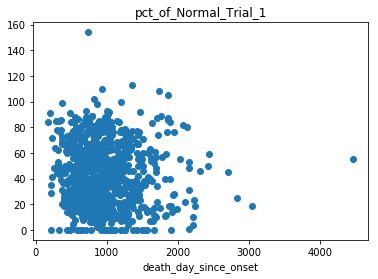

In [49]:
plt.scatter(min_normal_fvc['death_day_since_onset'], min_normal_fvc['pct_of_Normal_Trial_1'])
plt.title('pct_of_Normal_Trial_1')
plt.xlabel('death_day_since_onset')
plt.show()

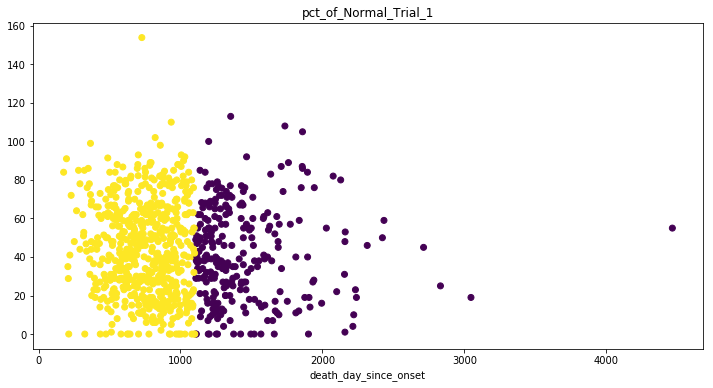

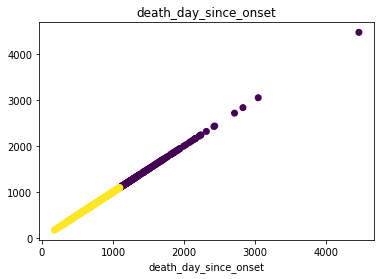

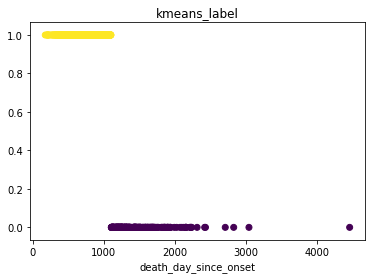

In [47]:
cluster_X = min_normal_fvc[['pct_of_Normal_Trial_1', 'death_day_since_onset']]

params = {'n_clusters':2, 'init':'k-means++', 'n_init':10, 'max_iter':300, 
          'tol':0.0001, 'precompute_distances':'auto', 'verbose':0, 
          'random_state':None, 'copy_x':True, 'n_jobs':None, 'algorithm':'auto'}
cluster_result = cluster(cluster_X, params)
plot_cluster(cluster_result)


## Plot FVC Percent of Normal - first few subjects

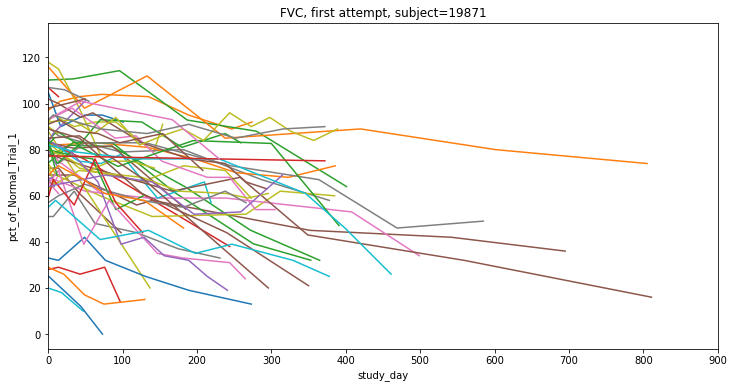

In [130]:
#plot first 100 subjects data 
#fvc_death
subject_list = fvc_death['subject_id'].unique()[0:200]
time = 'study_day'
feature = 'pct_of_Normal_Trial_1'
xlim=(0,900)
plot_fvc_long(fvc_death, feature, time, subject_list, xlim)

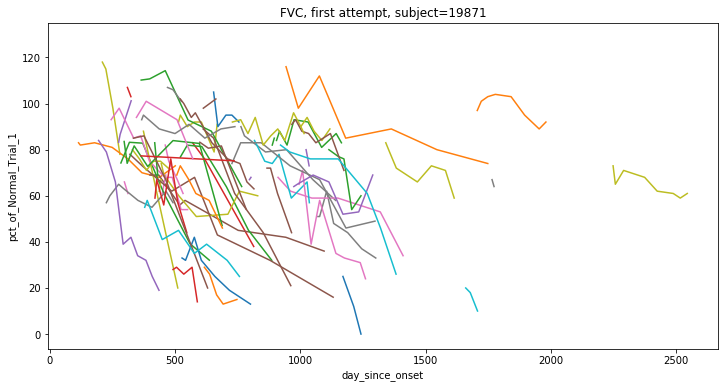

In [132]:
#plot first 100 subjects data 
#fvc_death
subject_list = fvc_death['subject_id'].unique()[0:200]
time = 'day_since_onset'
feature = 'pct_of_Normal_Trial_1'
xlim=(0,900)
plot_fvc_long(fvc_death, feature, time, subject_list, xlim=None)

## Plot FVC Liters - first few subjects

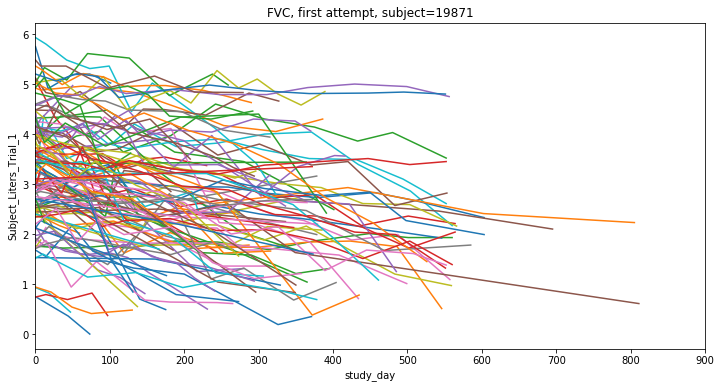

In [368]:
#plot first 100 subjects data 
#fvc_death
subject_list = fvc_death['subject_id'].unique()[0:200]
time = 'study_day'
feature = 'Subject_Liters_Trial_1'
xlim=(0,900)
plot_fvc_long(fvc_death, feature, time, subject_list, xlim)

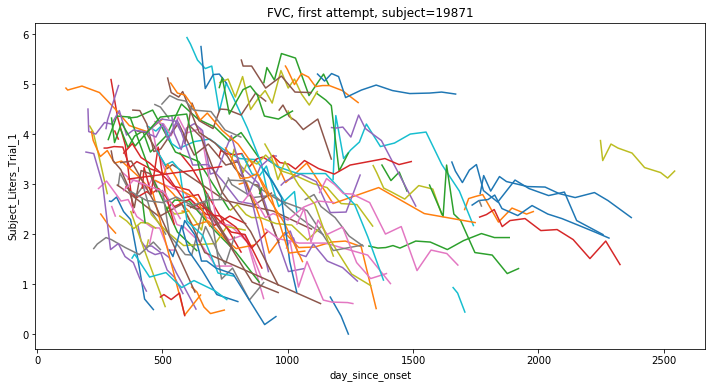

In [366]:
#plot first 100 subjects data 
#fvc_death
subject_list = fvc_death['subject_id'].unique()[0:200]
time = 'day_since_onset'
feature = 'Subject_Liters_Trial_1'
xlim=(0,900)
plot_fvc_long(fvc_death, feature, time, subject_list)

## FVC at baseline

In [ ]:
sum(fvc_death[ fvc_death['subject_id']==708]['death_day_since_onset'].isna())

## Make slope for precent normal FVC measures with Anchor at Onset

In [50]:
# add anchor point at onset for each subject.
# group by subject_id
anchor_fvc = fvc_death.groupby('subject_id').count()
print(anchor_fvc.shape)
anchor_fvc.head()

# remove all cells where pct_of_Normal_Trial_1 == 0
anchor_fvc = anchor_fvc[ anchor_fvc['pct_of_Normal_Trial_1'] != 0]
print(anchor_fvc.shape)
anchor_fvc.head()

# make all values = np.NaN
anchor_fvc[ anchor_fvc != np.NaN] = np.NaN
anchor_fvc.head()

# replace individual scores as needed.
anchor_fvc['pct_of_Normal_Trial_1'].replace(np.NaN,100, inplace=True)
anchor_fvc['day_since_onset'].replace(np.NaN,0, inplace=True)

# reset the index (groupby indexed changed)
anchor_fvc.reset_index(inplace=True)

print(anchor_fvc.shape)
anchor_fvc.head()

(8848, 11)


,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,day_since_onset,death_day_since_onset
subject_id,,,,,,,,,,,
89,1,0,0,0,0,0,1,0,1,0,0
329,8,8,8,0,8,0,0,0,8,8,0
406,1,0,0,0,0,0,1,0,1,0,0
411,1,0,0,0,0,0,1,0,1,0,0
533,2,2,2,0,2,0,0,0,2,2,0


(4229, 11)


,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,day_since_onset,death_day_since_onset
subject_id,,,,,,,,,,,
329,8,8,8,0,8,0,0,0,8,8,0
533,2,2,2,0,2,0,0,0,2,2,0
586,1,1,1,1,1,1,1,0,1,1,0
708,7,7,7,0,7,0,0,0,7,7,7
902,7,7,7,7,7,7,7,0,7,7,0


,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,day_since_onset,death_day_since_onset
subject_id,,,,,,,,,,,
329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(4229, 12)


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,day_since_onset,death_day_since_onset
0,329,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,533,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,586,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,708,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,902,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


(53085, 12)


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,day_since_onset,death_day_since_onset
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0,NaN,NaN
1,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0,1706.0,NaN
2,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0,1722.0,NaN
3,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0,1748.0,NaN
4,329,2.79,104.0,2.62,NaN,2.61,NaN,NaN,NaN,72.0,1778.0,NaN


In [55]:
# merge g_so with so
anchor_fvc_death = pd.concat([fvc_death, anchor_fvc])
print(anchor_fvc_death.shape)
anchor_fvc_death.head()

anchor_fvc_death.sort_values(by=['subject_id', 'day_since_onset'], inplace=True)
anchor_fvc_death.reset_index(drop=True, inplace=True)
print(anchor_fvc_death.shape)
anchor_fvc_death.head()

(53085, 12)


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,day_since_onset,death_day_since_onset
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0,NaN,NaN
1,329,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0,1706.0,NaN
3,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0,1722.0,NaN
4,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0,1748.0,NaN


In [98]:
# create linear regressions from the fvc normalized data
subject_col='subject_id'
y_col='pct_of_Normal_Trial_1'
x_col='day_since_onset'
y_label = 'pct_of_Normal_Trial_1'

full_result, mini_table = linreg_scalers(anchor_fvc_death.copy(), subject_col, y_col, x_col, y_label)

In [100]:
linreg_fvc_full = full_result
linreg_fvc_full.head()

,subject_id,test,slope_pct_of_Normal_Trial_1,intercept_pct_of_Normal_Trial_1
0,329,pct_of_Normal_Trial_1,-0.00207281,101.59
1,533,pct_of_Normal_Trial_1,-0.0228949,100.039
2,586,pct_of_Normal_Trial_1,-0.097493,100
3,708,pct_of_Normal_Trial_1,-0.0479417,101.911
4,902,pct_of_Normal_Trial_1,-0.0192037,101.193


In [101]:
linreg_fvc= mini_table
linreg_fvc.head()

,subject_id,slope_pct_of_Normal_Trial_1
0,329,-0.00207281
1,533,-0.0228949
2,586,-0.097493
3,708,-0.0479417
4,902,-0.0192037


In [102]:
# save to csv
filename = 'clean_data/fvc_slope.csv'
linreg_fvc.to_csv(filename, index=False)

In [103]:
# are fvc slopes associated with death in this subset?
fvc_percent_slope_death = linreg_fvc_full.merge(min_normal_fvc, how='left', on='subject_id')
fvc_percent_slope_death.dropna(inplace=True)
print(fvc_percent_slope_death.shape)
fvc_percent_slope_death.head()

(859, 7)


,subject_id,test,slope_pct_of_Normal_Trial_1,intercept_pct_of_Normal_Trial_1,pct_of_Normal_Trial_1,day_since_onset,death_day_since_onset
3,708,pct_of_Normal_Trial_1,-0.0479417,101.911,33.0,1070.0,1320.0
19,3981,pct_of_Normal_Trial_1,-0.025486,106.724,78.0,210.0,292.0
31,6483,pct_of_Normal_Trial_1,-0.0804397,99.9558,62.0,437.0,670.0
32,6673,pct_of_Normal_Trial_1,-0.0732003,100.588,0.0,1170.0,1253.0
37,8258,pct_of_Normal_Trial_1,-0.0411731,102.122,34.0,911.0,1498.0


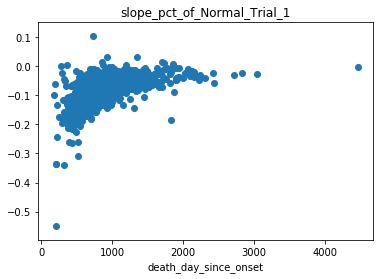

In [105]:
plt.scatter(fvc_percent_slope_death['death_day_since_onset'], fvc_percent_slope_death['slope_pct_of_Normal_Trial_1'])
plt.title('slope_pct_of_Normal_Trial_1')
plt.xlabel('death_day_since_onset')
plt.show()

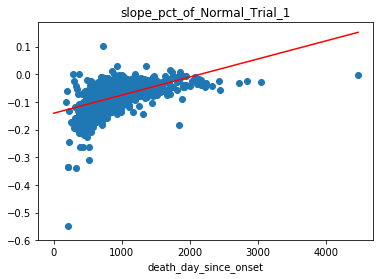

In [141]:
x = np.array(fvc_percent_slope_death['death_day_since_onset'].values)
y = np.array(fvc_percent_slope_death['slope_pct_of_Normal_Trial_1'].values)
slope, intercept, r_value, p_value, std_err = linregress(x.astype(float), y.astype(float))
plt.scatter(x, y)
X_plot = np.linspace(0,np.max(x),len(x))
plt.plot(X_plot, X_plot*slope + intercept, color='red')
plt.title('slope_pct_of_Normal_Trial_1')
plt.xlabel('death_day_since_onset')
plt.show()

## Make slope for FVC measures WITHOUT Anchor

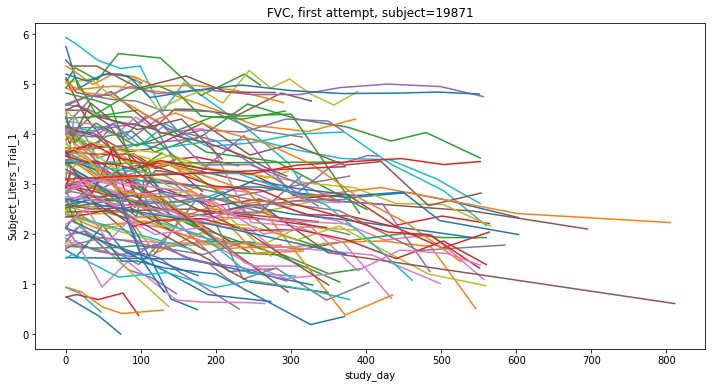

In [314]:
#plot first 100 subjects data 
subject_list = fvc_death['subject_id'].unique()[0:200]
time = 'study_day'
feature = 'Subject_Liters_Trial_1'
plot_fvc_long(fvc_death, feature, time, subject_list)

In [332]:
# the dataframe
df = fvc_death.copy()

# the columns
subject_col='subject_id'
y_col='Subject_Liters_Trial_1'
x_col='study_day'
y_label = 'fvc_liters'

# the function
full, mini = linreg_scalers(df, subject_col, y_col, x_col, y_label)


In [336]:
full_fvc_liters_slope = full.copy()
full_fvc_liters_slope.head()

,subject_id,test,slope_fvc_liters,intercept_fvc_liters
0,329,fvc_liters,-0.000990171,2.66443
1,533,fvc_liters,-0.0133333,1.92
2,649,fvc_liters,-0.00328227,3.35217
3,708,fvc_liters,-0.0044335,2.79759
4,902,fvc_liters,-0.00150547,2.49581


In [338]:
mini_fvc_liters_slope = mini.copy()
mini_fvc_liters_slope.head()

,subject_id,slope_fvc_liters
0,329,-0.000990171
1,533,-0.0133333
2,649,-0.00328227
3,708,-0.0044335
4,902,-0.00150547


In [339]:
# save to csv
filename = 'clean_data/fvc_liters_slope.csv'
mini_fvc_liters_slope.to_csv(filename, index=False)

-- end linear regression 

In [70]:
def plot_line_over_actuals(df_points, df_slope, subject_col, y_col_points, y_col_slope, y_col_inter, x_col, y_label):
    subject_list = df[subject_col].unique()
    for subj in subject_list:
        points = df_points[ df_points[subject_col]==subj]
        line = df_slope[ df_slope[subject_col]==subj]
        points_data = np.all(~np.isnan(points[y_col].values))
        if points_data and line.shape[0]!=0:
            plt.figure(figsize=(8,4))
            plt.plot(points[x_col].values, points[y_col_points].values, label="actual")
            plt.plot(points[x_col].values,
                     line[y_col_inter].values + line[y_col_slope].values * points[x_col].values, 
                     '-', label="predicted") 
            plt.title("{} : {}".format(subj,y_label))
            plt.ylabel(y_label)
            plt.xlabel(x_col)
            #plt.ylim(8,56)
            plt.show()

In [91]:
df_points.head()

,subject_id,pct_of_Normal_Trial_1,day_since_onset,death_day_since_onset
26809,557056,86.0,573.0,1260.0
26810,557056,73.0,623.0,1260.0
26811,557056,76.0,709.0,1260.0
26812,557056,44.0,819.0,1260.0
26813,557056,58.0,931.0,1260.0


In [92]:
df_slope.head()

,subject_id,test,slope_fvc_percent_of_normal,intercept
228,40971,fvc_percent_of_normal,NaN,NaN
262,49183,fvc_percent_of_normal,-0.0765125,105.066
670,131079,fvc_percent_of_normal,-0.0327369,104.499
671,131098,fvc_percent_of_normal,NaN,NaN
806,155668,fvc_percent_of_normal,-0.0492424,100


In [88]:
limit_subjects[0:20]

[327680,
 557056,
 622592,
 679940,
 499717,
 131079,
 40971,
 958478,
 647183,
 155668,
 958488,
 385050,
 131098,
 458780,
 958493,
 196639,
 49183,
 868385,
 237602,
 532520]

In [89]:
# plot a few subject's points with linear regression line
# note: only takes one assessment

# the dataframe
#plot first few subjects data 
limit_subjects = list(set(pre_linreg_fvc['subject_id']) & set(fvc_death['subject_id']))[0:20]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


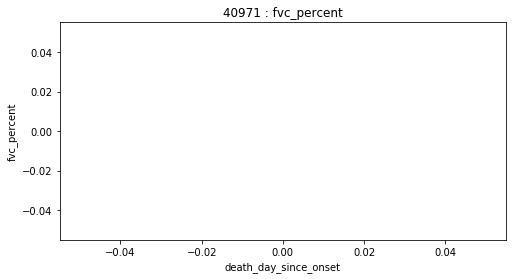

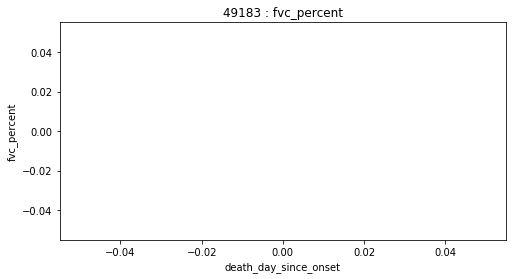

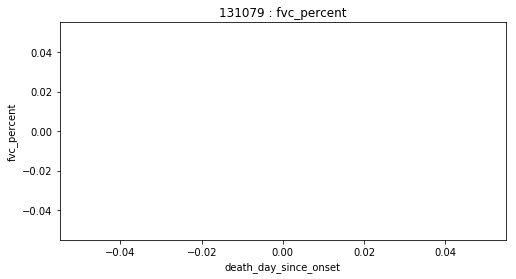

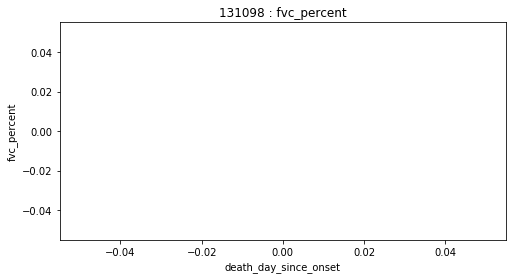

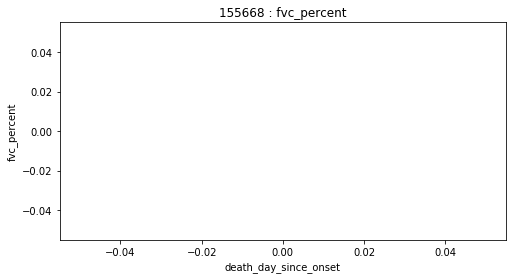

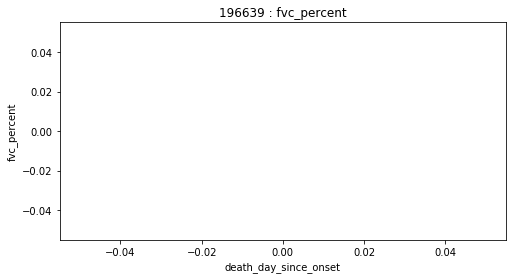

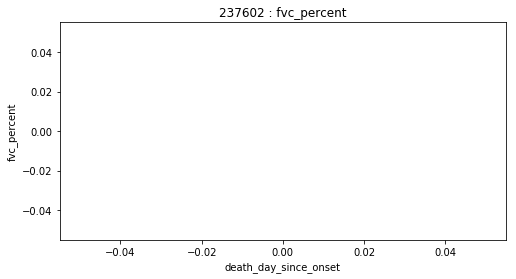

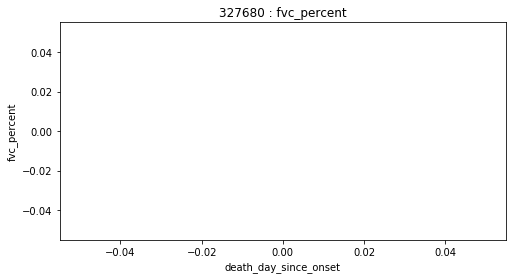

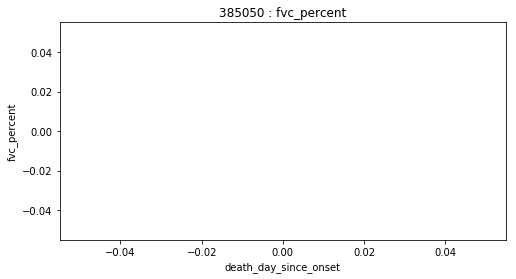

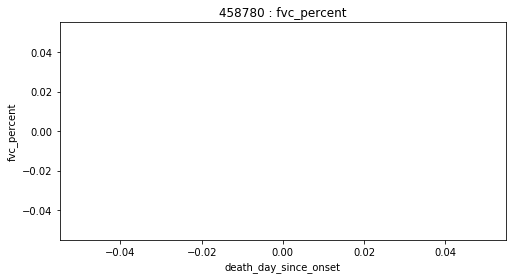

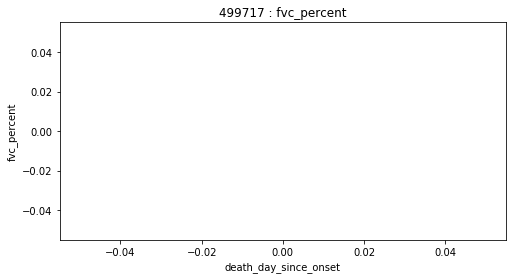

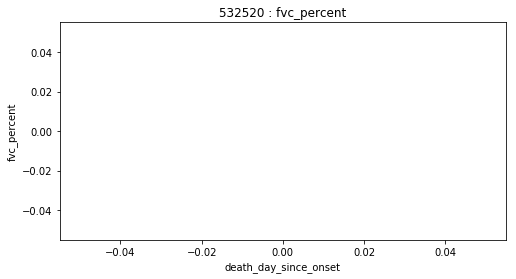

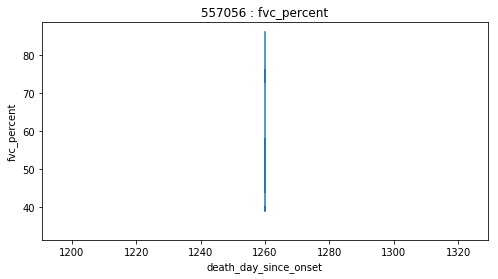

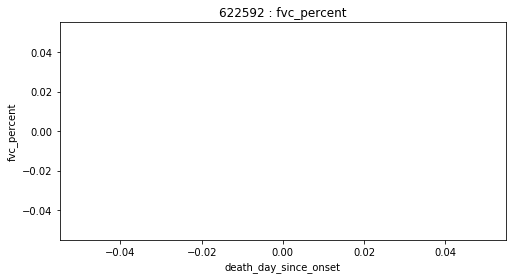

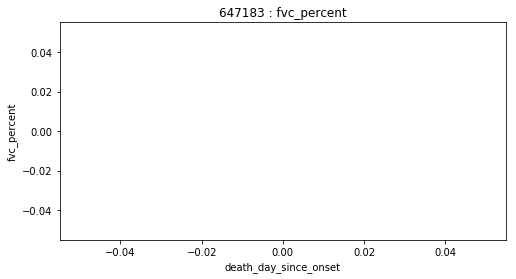

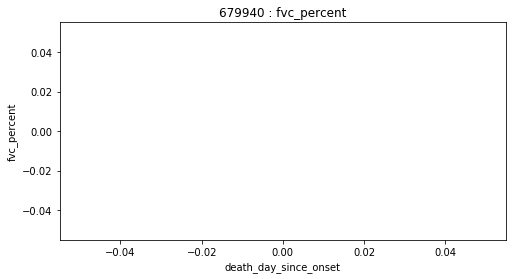

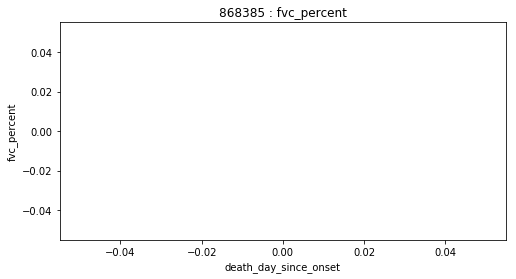

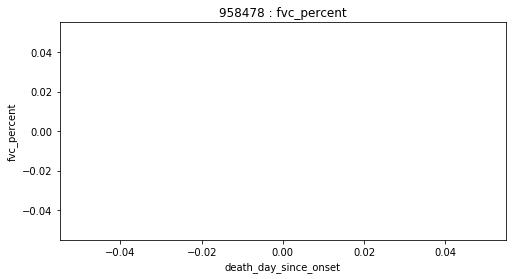

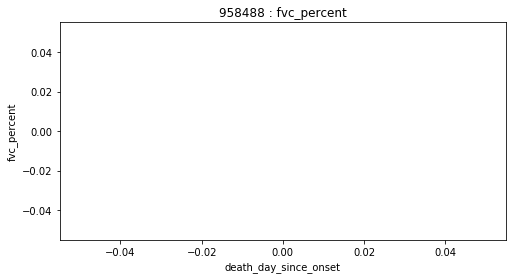

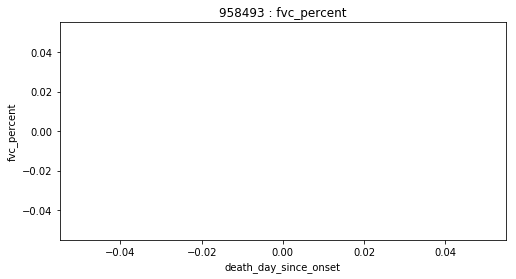

In [90]:
df_points = fvc_death_normal[ fvc_death['subject_id'].isin(limit_subjects)].copy()
df_slope = pre_linreg_fvc[ pre_linreg_fvc['subject_id'].isin(limit_subjects)].copy()

# the columns
subject_col='subject_id'
x_col='death_day_since_onset'
y_col_points='pct_of_Normal_Trial_1'
y_col_slope = 'slope_fvc_percent_of_normal'
y_col_inter = 'intercept'
y_label = 'fvc_percent'

plot_line_over_actuals(df_points, df_slope, subject_col, y_col_points, y_col_slope,
                       y_col_inter, x_col, y_label)

## max date of fvc values

In [12]:
fvc_onset.head()

,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,Onset_Delta,Diagnosis_Delta,delta_onset_diag,day_since_onset
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0,NaN,NaN,NaN,NaN
1,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0,-1706.0,-1068.0,638.0,1706.0
2,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0,-1706.0,-1068.0,638.0,1722.0
3,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0,-1706.0,-1068.0,638.0,1748.0
4,329,2.79,104.0,2.62,NaN,2.61,NaN,NaN,NaN,72.0,-1706.0,-1068.0,638.0,1778.0


In [14]:
temp_fvc = fvc_onset[['subject_id', 'day_since_onset']]
fvc_max_date = temp_fvc.groupby('subject_id').max()
fvc_max_date.reset_index(inplace=True)
fvc_max_date['max_fvc_date_onset'] = fvc_max_date['day_since_onset']
fvc_max_date.drop('day_since_onset', axis=1, inplace=True)
fvc_max_date.head()

,subject_id,max_fvc_date_onset
0,89,NaN
1,329,1980.0
2,406,NaN
3,411,NaN
4,533,1035.0


In [15]:
# save to csv
filename = 'clean_data/max_fvc_date.csv'
fvc_max_date.to_csv(filename, index=False)